# Time Series Application — STARTER NOTEBOOK

**Applied Machine Learning 2 @ Newman University**

*Prof. Ricky Boyer*

**Linh Toan**

**Important note!** Before you turn in this lab notebook, make sure everything runs as expected:

- First, **restart the kernel** -- in the menubar, select Kernel$\rightarrow$Restart.
- Then **run all cells** -- in the menubar, select Cell$\rightarrow$Run All.

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`

# Part 0: Sample dataset (Finance)

The dataset we'll be using is accessible via a Python library called quandl. If the following cell does not run for you, then you may need to do a `pip` or `conda` install to access the data in your environment. Once you do, then restart the kernel and run the cells again.

In [1]:
# %pip install quandl

In [2]:
# quandl for financial data
import quandl
import pandas as pd
import matplotlib.pyplot as plt
quandl.ApiConfig.api_key = 'bzv_VKSXDstz5DLXnjhe'
# Retrieve Textron data from Quandl
txt= quandl.get('WIKI/TXT')
# Retrieve the Boeing data from Quandl
ba = quandl.get('WIKI/BA')
txt.head(5)
print("\n(All data appears to be ready.)")


(All data appears to be ready.)


Here we've brought in financial data for 2 aircraft companies, so we may get a sense of scale. Our main concern will be the prediction of Textron ([TXT](https://search.yahoo.com/search?fr=mcafee&type=E210US1590G0&p=Textron+stock)) market cap as if we were computing this back in 2018, using historical data. First let's take a look at the stock prices of these companies over their lifetime.

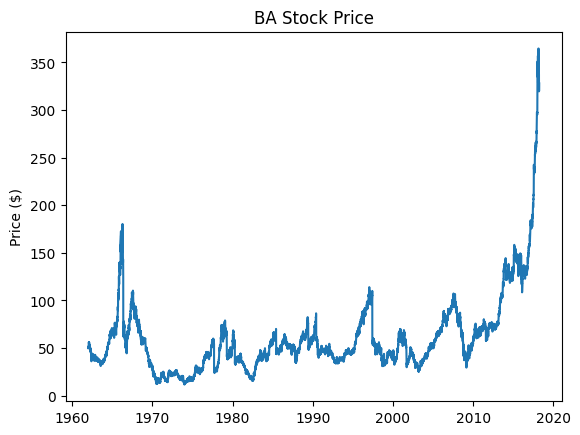

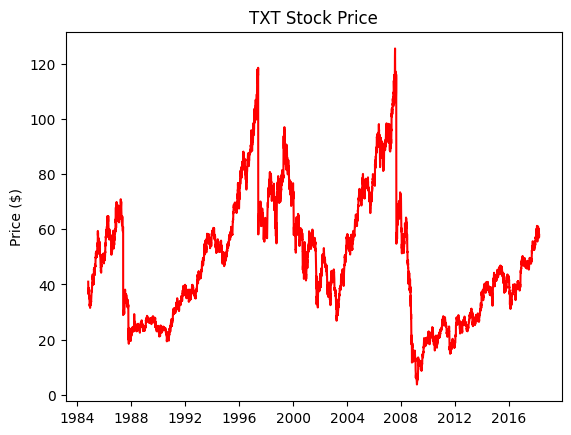

In [3]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(ba.index, ba['Close'])
plt.title('BA Stock Price')
plt.ylabel('Price ($)');
plt.show()
plt.plot(txt.index, txt['Close'], 'r')
plt.title('TXT Stock Price')
plt.ylabel('Price ($)');
plt.show();

## Prepping Our Data
Generally speaking, for almost any date-based analysis, it is  agood idea to include a Date column. Ours happens to be in the index currently. We should remove it from the index using the `reset_index` function, but first we can put it to good use. Let's make a column `Year` using that index.

In [4]:
# Create a year column
txt['Year'] = pd.DatetimeIndex(txt.index).year
ba['Year'] = pd.DatetimeIndex(ba.index).year

**Exercise 0** (10 points). Use the `reset_index` function, on our `txt` and `ba` DataFrames, with `level=0` and `inplace=True`. This should automatically give us a `Date` column in each of the datasets that virtually all time series models require, especially some of the newer ones like Prophet.


In [5]:
# Take Dates from index and move to Date column
## YOUR ANSWER HERE
# BEGIN SOLUTION
txt.reset_index(level=0, inplace=True)
ba.reset_index(level=0, inplace=True)
# END SOLUTION

In [6]:
# Test cell: `rest_index_test`
assert txt['Date'].dtype == 'datetime64[ns]', print("\n You do not have a 'Date' column in txt")
assert ba['Date'].dtype == 'datetime64[ns]', print("\n You do not have a 'Date' column in ba")

print("\n(Passed! You got 10 points!)")


(Passed! You got 10 points!)


Now let's calculate the target that we are after. If trying to determine the Market Cap of a company, it is determined (in simplest form) by taking the outstanding shares of that company (represented by `Adj. Volume` in our dataset) and multiplying it by the given price of that share. Our dataset has many different prices represented for each day, but we'll use `Close`.

**Exercise 1** (10 points). Create the column `Cap` in both the `txt` and `ba` datasets by multiplying the `Adj. Volume` with `Close`.

In [7]:
## YOUR ANSWER HERE
# BEGIN SOLUTION
txt['Cap'] = txt['Adj. Volume'] * txt['Close']
ba['Cap'] = ba['Adj. Volume'] * ba['Close']
# END SOLUTION

In [8]:
# Test cell: `Cap`
assert txt['Cap'].dtype == 'float64', print("\n You do not have a 'Cap' column in txt or datatype wrong")
assert ba['Cap'].dtype == 'float64', print("\n You do not have a 'Cap' column in ba or datatype wrong")
assert txt['Cap'].shape == (8424,), print("\n Shape txt['Cap'] is {} when it should be {}").format(txt['Cap'].shape, '(8424,)')
assert ba['Cap'].shape == (14155,), print("\n Shape txt['Cap'] is {} when it should be {}").format(ba['Cap'].shape, '(14155,)')

print("\n(Passed! You got 10 points!)")


(Passed! You got 10 points!)


If we look at the two together, we can now see the scale of dollars that we are dealing with, as well as determine the general trend of our data.

,Date,ba_cap,txt_cap
6353,2010-01-04,3.475688e+08,6.912662e+07
6354,2010-01-05,5.145098e+08,2.264221e+08
6355,2010-01-06,5.282460e+08,1.082151e+08
6356,2010-01-07,8.943800e+08,1.049093e+08
6357,2010-01-08,4.402306e+08,8.363952e+07
...,...,...,...
8419,2018-03-21,1.364169e+09,5.364942e+07
8420,2018-03-22,2.283063e+09,7.526130e+07
8421,2018-03-23,2.292040e+09,8.745160e+07
8422,2018-03-26,1.697882e+09,7.077725e+07


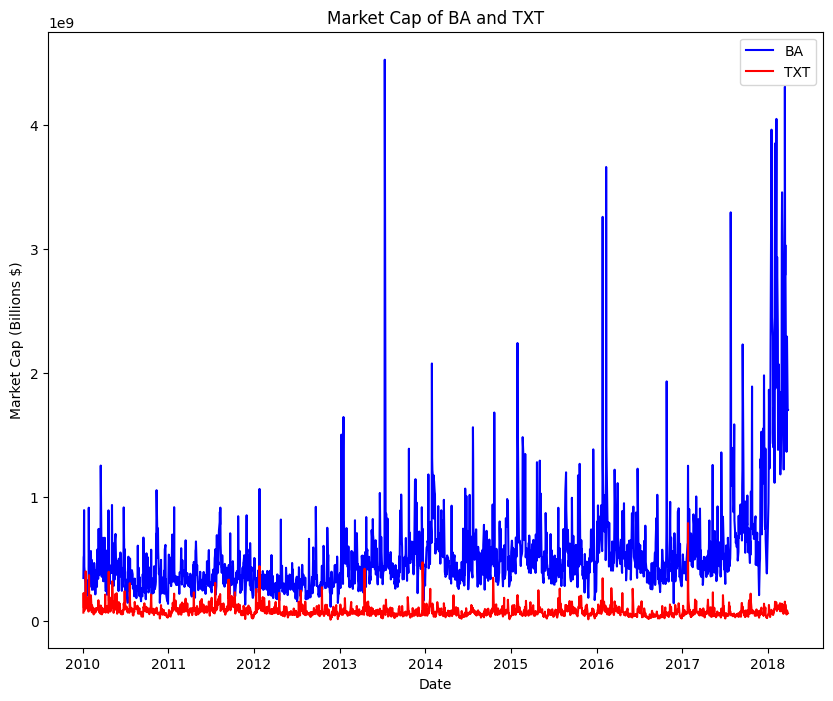

In [9]:
mkt_cap = ba.merge(txt, how='inner', on='Date')
mkt_cap.rename(columns={'Cap_x': 'ba_cap', 'Cap_y': 'txt_cap'}, inplace=True)
mkt_cap = mkt_cap.loc[mkt_cap['Date'] > '2010-1-1', :]

plt.figure(figsize=(10, 8))
plt.plot(mkt_cap['Date'], mkt_cap['ba_cap'], 'b-', label = 'BA')
plt.plot(mkt_cap['Date'], mkt_cap['txt_cap'], 'r-', label = 'TXT')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of BA and TXT')
plt.legend();
mkt_cap = mkt_cap[['Date', 'ba_cap', 'txt_cap']]
display(mkt_cap)

It appears that Boeing's markjet cap is much large than Textron's, though both can pretty easily be quantified in the Billions of dollars. We can also see the volatility in the day to day market. The hope would be that using our Time Series models has a smoothing effect over all that volatility. This view, however is much better than looking at it since the beginning of each company's entry onto the market.

**Exercise 2** (20 points). Slice the `txt` DataFrame such that you only keep the rows where `Date` is greater than '2010-1-1'. (**Hint:** If you look at my previous cell, you might be able to spot how I did it to the `mkt_cap` DataFrame.)

In [10]:
## YOUR ANSWER HERE
# BEGIN SOLUTION
txt = txt.loc[txt['Date'] > '2010-1-1', :]
# END SOLUTION

In [11]:
# Test cell: `date_slice`
assert txt.shape == (2071, 15), "Shape txt is {} when it should be {}".format(txt.shape, '(2071, 15)')
try:
    test = txt.loc[txt['Date'] < '2010-1-1', :]
    test.shape == (0,15)
    print("\n(Passed! You got 20 points!)")
except AssertionError as e:
    print("\n(Seems like you may still have some unwanted rows.)")


(Passed! You got 20 points!)


## Notation and review

Taking a look at the model explanations from [Toward Data Science](https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6) we can determine which model we may want to use, as well as a general explanation of how it works.

### Autoregression (AR)
**Autoregression** utilizes a $p$ parameter to determine how many lag variables we use in the regression to determine the next value, according to the following formula. Setting this value to 1 begins to introduce randomness into the algorithm, shifting away from a normal regression.

### Moving Average (MA)
The **Moving Average** portion of time series algorithms utilizes a $q$ parameter to determine how many lag variables to use when determining the average. In an $q$ = 1 model, our forecast is a constant term plus the previous white noise term times a multiplier, added with the current white noise term.

### ARMA
The **ARMA** model is the combination of the previous two sections in one algorithm, acting as the basic framework for most TS analyses used in business today.

### ARIMA
**ARIMA** utilizes the ARMA model and a difference order as defined by $I(d)$.

### SARIMA
**SARIMA** is an ARIMA model that has additional ability to difference based on seasonality as defined within the parameters of the formula. It expressed as a function is shown belw, which is a far cry from the original AR model.

For our purposes, both the ARIMA and SARIMA models can be accessed via our friendly [Statsmodels package](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) from the lesson on Regression! Let's go ahead and pull in that model as well as some of it' visualization tools.

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Fitting a model

We've arrived at the main event! Let's check out what this looks like when we run a very basic model where $(p, d, q)$ are all set to 0 and we have no seasonality introduced. This should allow us to check out the baseline summary statistics.

In [13]:
# 0,0,0 ARIMA Model
model = ARIMA(txt.Cap, order=(0,0,0), seasonal_order=(0,0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Cap   No. Observations:                 2071
Model:                          ARIMA   Log Likelihood              -46424.964
Date:                Mon, 03 Jun 2024   AIC                          92853.927
Time:                        23:58:41   BIC                          92865.199
Sample:                             0   HQIC                         92858.059
                               - 2071                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.301e+07   2.17e+09      0.038      0.969   -4.17e+09    4.33e+09
sigma2      4.704e+18      0.042   1.12e+20      0.000     4.7e+18     4.7e+18
Ljung-Box (L1) (Q):                 468.75   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


We want to make sure each term in our model is statistically significant, which we can see by taking a look at the highlighted section. We want each term to have a p-value of less than 0.05, so we can reject the null hypothesis with statistically significant values.

We can see that the Constant value is way off from the .05 or less that we need it to be in order to show statistical significance.

**Let's get Experimental!** Like most of our algorithms, the feature engineering is what tends to produce better results within the output models, however time series analysis allows us to adjust the regressor variables in real time as hyperparameters of the algorithm. It seems like a good idea to play around with the parameters a bit to see if we can get something a little better.


**Exercise 3** (20 points). Copy and paste my ARIMA code cell into the next code cell, then adjust `order` parameter to be $(p, d, q)$ = (3, 1, 3). Keep the `model` and `model_fit` variables as they are.

In [14]:
# 3,1,3 ARIMA Model
##YOUR CODE HERE
#BEGIN SOLUTION
model = ARIMA(txt.Cap, order=(3,1,3), seasonal_order=(0,0,0,0))
model_fit = model.fit()
print(model_fit.summary())
#END SOLUTION
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    Cap   No. Observations:                 2071
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -39241.950
Date:                Mon, 03 Jun 2024   AIC                          78497.900
Time:                        23:58:54   BIC                          78537.347
Sample:                             0   HQIC                         78512.359
                               - 2071                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5432      0.021    -72.407      0.000      -1.585      -1.501
ar.L2         -0.1797      0.032     -5.647      0.000      -0.242      -0.117
ar.L3          0.3967      0.017     23.581      0.0

In [15]:
# Test cell: `313_arima`
test = [-1.1426154273752298, -0.17615361681405473, 0.19028340170350158, 0.6153019057970129, -0.5937619644101406, -0.5453617963385642, 1741955193198740.8]
# assert test == list(model.start_params), "Check your cell again. It should look exactly like before with order = (3 ,1 ,3)"
# print("\n(Passed! You got 20 points!)")
print(f"Test values: {test}")
print()
print(f"Model values: {model.start_params}")

Test values: [-1.1426154273752298, -0.17615361681405473, 0.19028340170350158, 0.6153019057970129, -0.5937619644101406, -0.5453617963385642, 1741955193198740.8]

Model values: [-1.14261543e+00 -1.76153617e-01  1.90283402e-01  6.15301906e-01
 -5.93761964e-01 -5.45361796e-01  1.74195519e+15]


From a variable standpoint this looks much better as all seem to have a $p$ value lower than .05. However, when we check the statistics based on our normal regression assumtions, we now see low heteroskedasticity, as well as high $p$ values for the Ljun-Box test and the heteroskedasticity. this indicates that we cannot rejcet the assumed state of violating those assumptions.

Can adding in the `seasonal_order` parameter help us get on track?

**Exercise 4** (30 points). Copy and paste the ARIMA code cell into the next code cell. Keep the `order` parameter as $(p, d, q)$ = (3, 1, 3) and the `model` and `model_fit` variables as they are. Then go ahead and play with the `seasonal_order` parameter, setting it to something other than $(P, D, Q, s)$ = (0, 0, 0, 0).

In [16]:
# 1,1,0 ARIMA Model
##YOUR CODE HERE
#BEGIN SOLUTION
model = ARIMA(txt.Cap, order=(3,1,3), seasonal_order=(3,1,3,10))
model_fit = model.fit()
print(model_fit.summary())
#END SOLUTION

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                                    SARIMAX Results                                     
Dep. Variable:                              Cap   No. Observations:                 2071
Model:             ARIMA(3, 1, 3)x(3, 1, 3, 10)   Log Likelihood              -39256.865
Date:                          Tue, 04 Jun 2024   AIC                          78539.731
Time:                                  00:01:04   BIC                          78612.927
Sample:                                       0   HQIC                         78566.567
                                         - 2071                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2464      0.192      1.286      0.198      -0.129       0.622
ar.L2          0.9327      0.123      7.597      0.

In [17]:
# Test cell: `sarima`
#Yay a free 30 points for getting the above to run! You'll all have something different, but as long as it runs you'll get the points.
print("\n(Passed! You got 30 points!)")


(Passed! You got 30 points!)


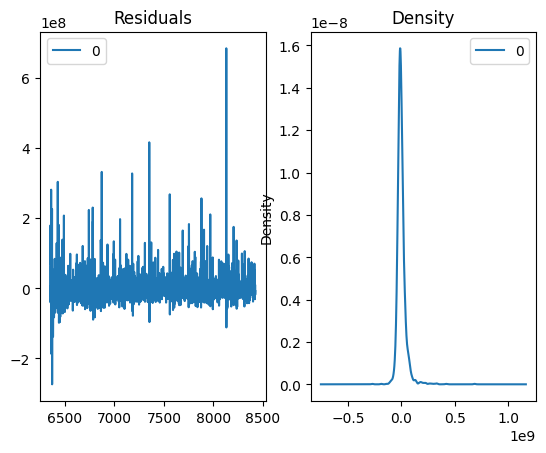

In [18]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

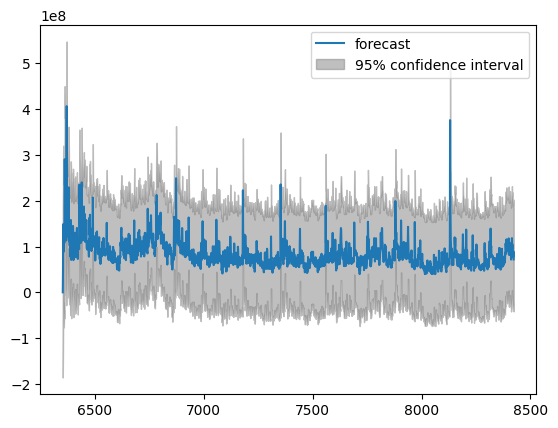

In [19]:
# Actual vs Fitted
plot_predict(model_fit, dynamic=False)
plt.show()

# Other Algorithms and Packages
There are a few more packages that we would be a little remissed if we did not talk about:

### Auto ARIMA
Auto arima is part of the [pmdarima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) package that allows for optimized and iterable runs of the ARIMA function through a helpful configuration function. It allows you to set a `start_p`, `max_p`, `start_q`, and `max_q` parameters so it can iterate through each model, determining which best fits the test given. It also has a few more advanced regression parameters like the ability to run the model stepwise in considering each regression variable.

### Prophet
[Prophet](https://facebook.github.io/prophet/docs/quick_start.html) is the time series algorithm developed by Meta (formaerly Facebook) and is widely considered one of the better time series models out there right now. It is also built in such a way that makes predictions very easy to accomplish, necessitating only a few lines of code. The only finnicky thing about it is that it requires a `ds` field (in the form of a date series) and a `y`

Let's go ahead and install those packages. You may need to `!pip` or `conda` install them to get them to work.

In [20]:
# %pip install pmdarima

In [21]:
import pmdarima as pm
from prophet import Prophet

Let's see if the automated version can generate a better model than earlier.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2071
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -39241.950
Date:                Tue, 04 Jun 2024   AIC                          78497.900
Time:                        00:04:34   BIC                          78537.347
Sample:                             0   HQIC                         78512.359
                               - 2071                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5432      0.021    -72.407      0.000      -1.585      -1.501
ar.L2         -0.1797      0.032     -5.647      0.000      -0.242      -0.117
ar.L3          0.3967      0.017     23.581      0.0

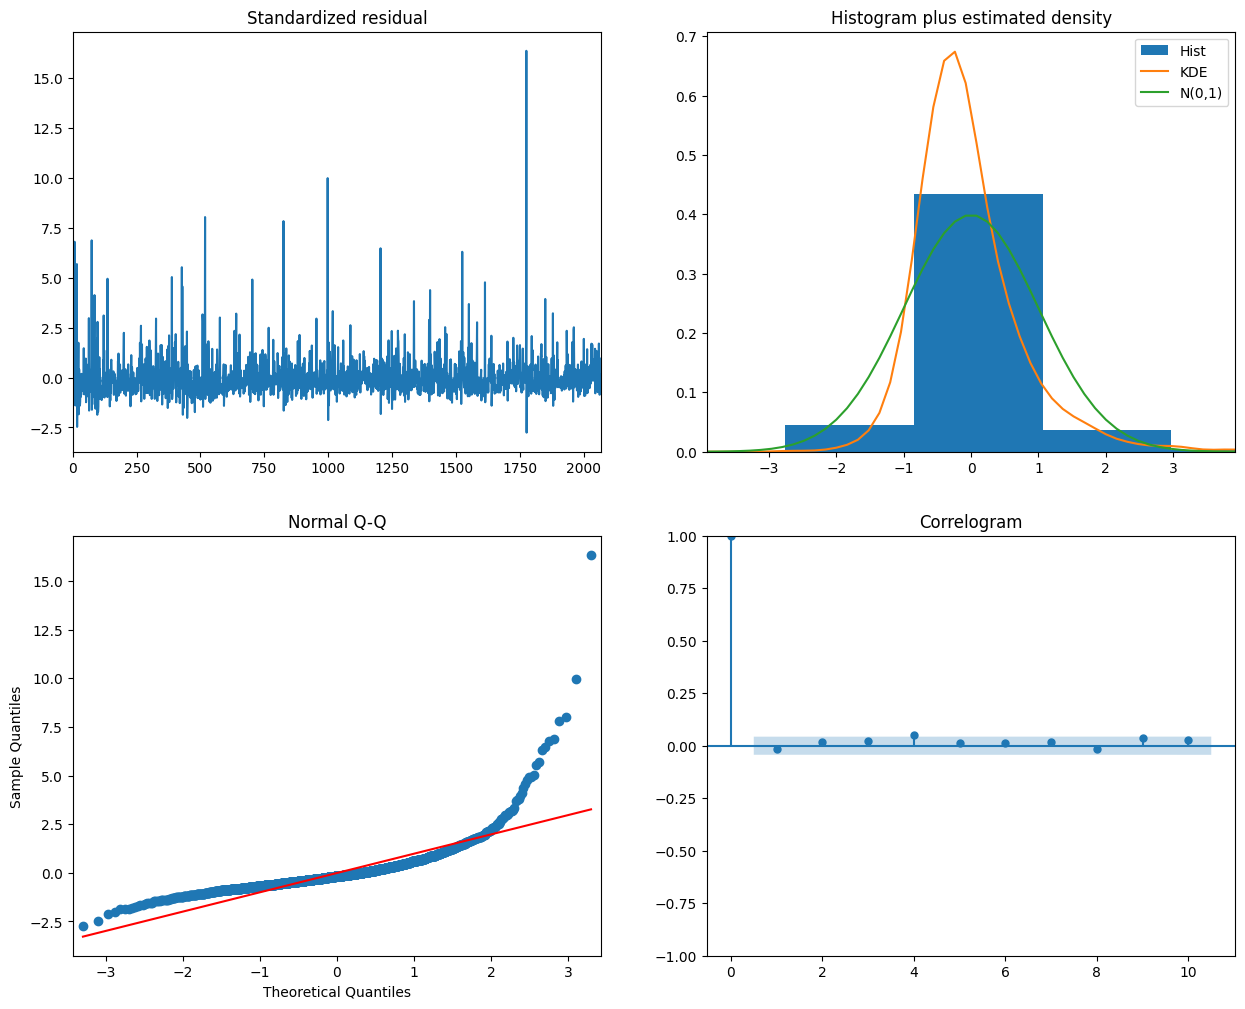

In [22]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(txt['Cap'],
                      start_p=0,
                      start_q=0,
                      test='kpss', #default
                      max_p=3, max_q=3, # maximum p and q
                      m=7, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

print(ARIMA_model.summary())

ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

It seems that our earlier $(p, d, q)$ = (3,1,3) is about as good as it is going to get for this data. Each overall coefficient in the regression is statistically significant even if there is some imbalance overall in the dataset. Time series are much harder to balance than our priior classification models since they require a value for each date in the series. Other options at this point would be restructuring our dataframe to be organized by week or month. Overall, though, for a business something like this still helps us determine the regressive components of the market cap, allowing us to glean insight from the selected model itself, prior to any forecasting.

Let's do a little forecasting with the [Prophet](https://facebook.github.io/prophet/docs/quick_start.html). Open up the documentation, and let's walk through the first few steps.

**Exercise 5** (30 points). Complete the checklist:
* Create DataFrame `txt` by renaming the current column `Date` to `ds` and the column `Cap` to `y`
* Create `txt_prophet` by instantiating a new `Prophet()` object, but let's include `changepoint_prior_scale=0.15` in the Prophet configuration.
* Fit the `txt_prophet` object to our intial `txt` DataFrame

In [23]:
##YOUR ANSWER HERE
#BEGIN SOLUTION
# Prophet requires columns ds (Date) and y (value)
txt = txt.copy()
txt.rename(columns={'Date': 'ds', 'Cap': 'y'}, inplace=True)
# Make the prophet model and fit on the data
txt_prophet = Prophet(changepoint_prior_scale=0.15)
txt_prophet.fit(txt)
#END SOLUTION

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9sekwluz/tpknekw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9sekwluz/8g421p8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99578', 'data', 'file=/tmp/tmp9sekwluz/tpknekw2.json', 'init=/tmp/tmp9sekwluz/8g421p8l.json', 'output', 'file=/tmp/tmp9sekwluz/prophet_modelc2zo58ua/prophet_model-20240604000435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:04:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:04:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [24]:
# Test cell: `prophet_prep`
try:
    test1 = txt['Date']
except KeyError:
    pass
except AttributeError:
    pass
except NameError:
    pass
try:
    print(txt_prophet)
except KeyError:
    print('txt_prophet does not exist')
except AttributeError:
    print('txt_prophet does not exist')
except NameError:
    print('txt_prophet does not exist')

print("\n(Passed! You got 30 points!)")


(Passed! You got 30 points!)


**Exercise 6** (30 points). Complete the checklist:
* Create DataFrame `txt_forecast` by using the `make_future_dataframe` function for 2 years worth of days (periods= 365*2, freq='D')
* Use the `.predict` method from our `txt_prophet` on our newly created `txt_forecast` DataFrame.

In [25]:
##YOUR ANSWER HERE
#BEGIN SOLUTION
# Make a future dataframe for 2 years
txt_future = txt_prophet.make_future_dataframe(periods=365*2, freq='D')
# Make predictions
txt_forecast = txt_prophet.predict(txt_future)
#END SOLUTION

In [26]:
# Test cell: `prophet_predict`

try:
    prophet_predict_test = txt_forecast.iloc[:, [1, 2, 5]]
except AttributeError:
    print('Something is wrong with your prediction')

assert list(prophet_predict_test.columns) == ['trend', 'yhat_lower', 'trend_upper'], print('Something is wrong with your prediction')

print("\n(Passed! You got 30 points!)")


(Passed! You got 30 points!)


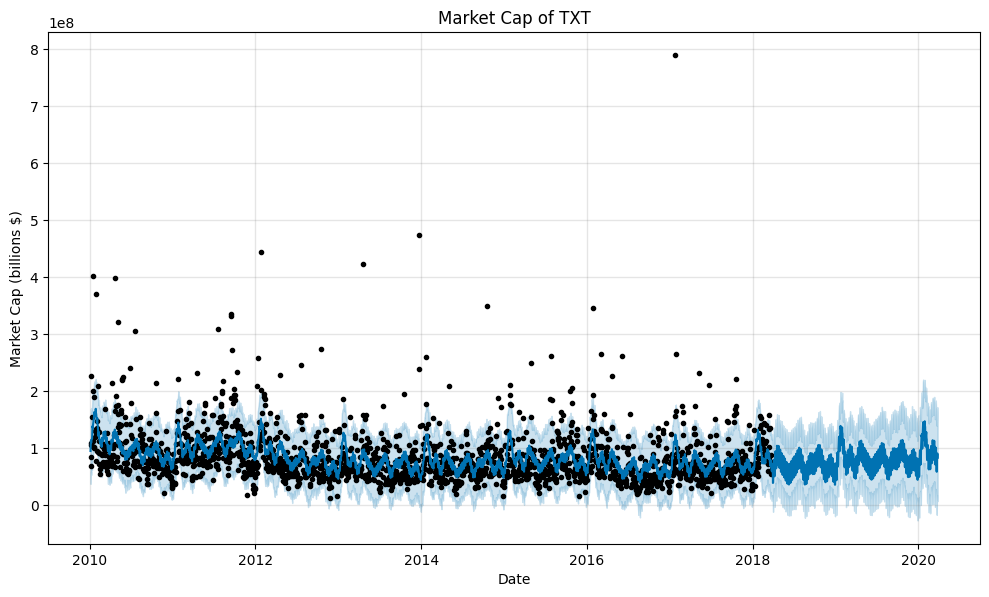

In [27]:
txt_prophet.plot(txt_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of TXT');

**Congrats!** If you've gotten this far without errors, you're ready to submit your notebook! Be sure to Restart the Kernel and Run All Cells from the beginning.